In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(10,6)})

In [2]:
losses = torch.load('models/unpruned_mse_logspace_losses.pt')
print(losses)

[8.649924516677856, 2.694224715232849, 2.848963975906372, 1.7113630771636963, 1.1938273906707764, 1.063882976770401, 0.6432907581329346, 0.6002940535545349, 0.4449475258588791, 0.42608289420604706, 0.4563325494527817, 0.3847976624965668, 0.36393560469150543, 0.3616538494825363, 0.3350331783294678, 0.3479425609111786, 0.3362288475036621, 0.3071855306625366, 0.30345605313777924, 0.28463447093963623, 0.287080317735672, 0.29201018810272217, 0.2842598408460617, 0.2812007963657379, 0.2733724117279053, 0.27583378553390503, 0.274539090692997, 0.27132559567689896, 0.2672532647848129, 0.26463064551353455, 0.2653265669941902, 0.2636733576655388, 0.26128077507019043, 0.258164219558239, 0.25736598670482635, 0.2562427297234535, 0.2545923441648483, 0.25233450531959534, 0.25106875598430634, 0.25010430812835693, 0.24842188507318497, 0.2462976947426796, 0.2450127750635147, 0.24385375529527664, 0.24227126687765121, 0.24072137475013733, 0.23970182985067368, 0.2384149581193924, 0.2369031384587288, 0.235788

c:\Users\Vince\anaconda3\envs\wise_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Vince\anaconda3\envs\wise_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Loss')

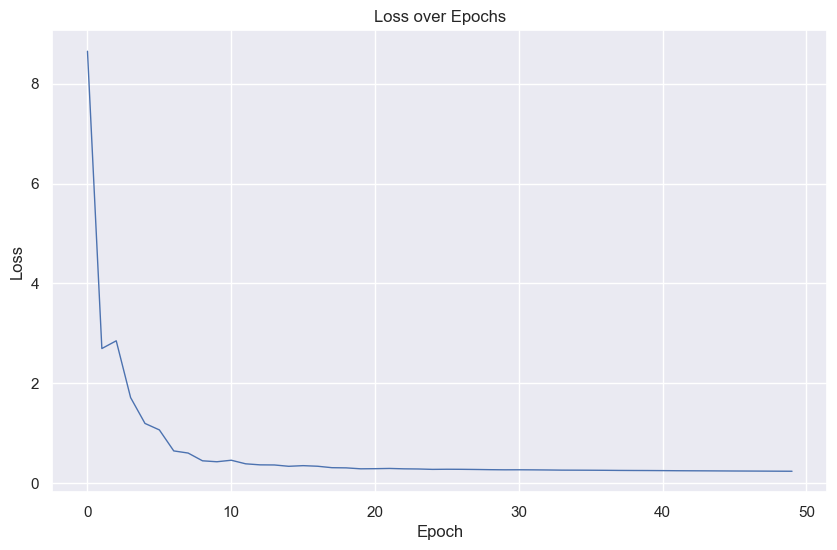

In [3]:
ax = sns.lineplot(losses, linewidth=1)
ax.set_title('Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


# Model Performance Visualizations

In [4]:
# Setup Model
from model import GCN

model = GCN()
print(model)
model.load_state_dict(torch.load("models/unpruned_mse_logspace.pt"))
model = model.eval()

GCN(
  (relu): ReLU()
  (conv1): SAGEConv(2, 32, aggr=mean)
  (conv2): SAGEConv(32, 128, aggr=mean)
  (conv3): SAGEConv(128, 128, aggr=mean)
  (conv4): SAGEConv(128, 128, aggr=mean)
  (conv5): SAGEConv(128, 128, aggr=mean)
  (lin): Linear(in_features=128, out_features=1, bias=True)
  (leaky): LeakyReLU(negative_slope=0.01)
)


In [5]:
data = torch.load("datasets/unpruned/SG256_SM_Only_Test.pt")

y_truth = np.array([])
y_pred = np.array([])
for graph in data:
    graph.x = torch.tensor([[data[0], data[1]] for data in graph.x])

    # Logspace calcs
    graph.y = torch.log10(graph.y)
    graph.x[:, 0] = torch.log10(graph.x[:, 0])

    for item in graph.y:
        y_truth = np.append(y_truth, item)

    out = model(graph)
    for item in out.tolist():
        y_pred = np.append(y_pred, item[0])

# unlogspace
# y_truth = 10 ** y_truth
# y_pred = 10 ** y_pred

print(len(y_pred), "total halo snapshots")

1749 total halo snapshots


c:\Users\Vince\anaconda3\envs\wise_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Vince\anaconda3\envs\wise_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Pearson correlation: PearsonRResult(statistic=0.33939156684885863, pvalue=2.104168040816906e-48)
Mean absolute error: 0.38212365256233716 dex
Scatter: 0.5841657924741733 dex
Bias: 0.03180271356428876 dex
R^2: 0.10729750832020624


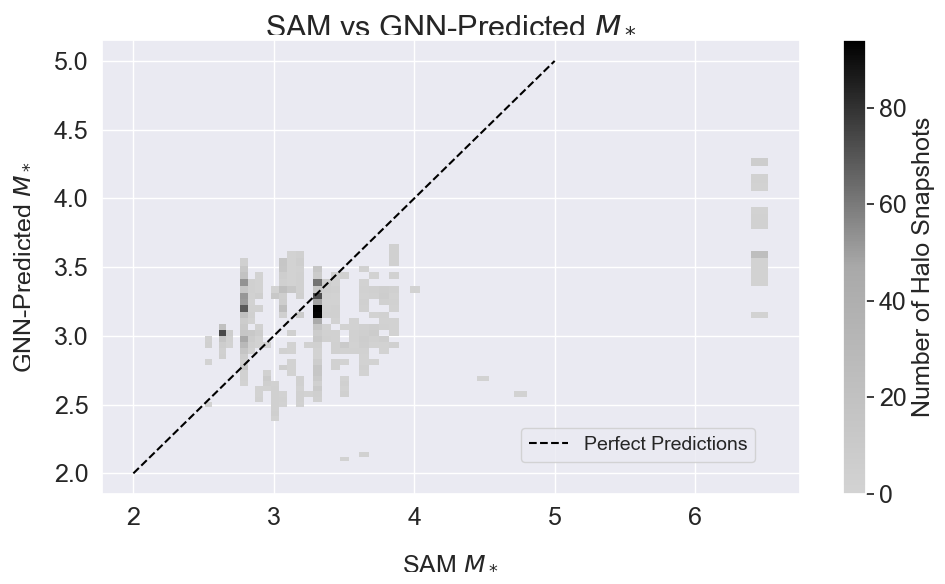

In [9]:
import scipy.stats
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import r2_score

# Histogram params
num_x_bins = 50
num_y_bins = 50

# Set the minimum and maximum values for the x-axis and y-axis
x_min, x_max = np.min(y_truth), np.max(y_truth)
y_min, y_max = np.min(y_pred), np.max(y_pred)

# Create logarithmically spaced bins for the x-axis and y-axis
x_bins = np.logspace(np.log10(x_min), np.log10(x_max), num_x_bins + 1)
y_bins = np.logspace(np.log10(y_min), np.log10(y_max), num_y_bins + 1)

# Define custom color palette from gray to black
g = sns.color_palette(["lightgray", "darkgray", "black"])

# Create a colormap object with the custom palette
cmap_g = LinearSegmentedColormap.from_list("custom_gray_to_black", g)
ax = sns.histplot(x=y_truth, y=y_pred, bins=[x_bins, y_bins], cmap=cmap_g)
ax.set_title("SAM vs GNN-Predicted $M_*$", fontsize=22)

# Create colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label("Number of Halo Snapshots", fontsize=18)
cbar.ax.tick_params(labelsize=18)

# Label axes
xlabel = ax.set_xlabel("SAM $M_*$", fontsize=18, labelpad=15)
ylabel = ax.set_ylabel("GNN-Predicted $M_*$", fontsize=18, labelpad=15)
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

# Plot perfect predictions line y=x
plt.plot([2, 5], [2, 5], ls="--", c="0")
plt.legend(
    ["Perfect Predictions"], loc="lower right", bbox_to_anchor=(0.95, 0.05), fontsize=14
)

plt.tight_layout()
plt.savefig("./images/figure1.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

residuals = y_truth - y_pred
print(f"Pearson correlation: {scipy.stats.pearsonr(y_truth, y_pred)}")
print(f"Mean absolute error: {np.mean(np.abs(residuals))} dex")
print(f"Scatter: {scipy.stats.tstd(residuals)} dex")
print(f"Bias: {np.mean(residuals)} dex")
print(f"R^2: {r2_score(y_true=y_truth, y_pred=y_pred)}")

In [7]:
# Split for deeper analysis
large_idx = y_truth > 1e3
y_truth_large = y_truth[large_idx]
y_pred_large = y_pred[large_idx]

y_truth_small = y_truth[~large_idx]
y_pred_small = y_pred[~large_idx]

In [8]:
# Histogram params
num_x_bins = 50
num_y_bins = 50

# Set the minimum and maximum values for the x-axis and y-axis
x_min, x_max = np.min(y_truth_large), np.max(y_truth_large)
y_min, y_max = np.min(y_pred_large), np.max(y_pred_large)

# Create logarithmically spaced bins for the x-axis and y-axis
x_bins = np.logspace(np.log10(x_min), np.log10(x_max), num_x_bins + 1)
y_bins = np.logspace(np.log10(y_min), np.log10(y_max), num_y_bins + 1)

ax = sns.histplot(x=y_truth_large, y=y_pred_large, bins=[x_bins, y_bins], cmap='inferno')
ax.set_title('"Large Halos": Predicted vs Actual Steller Mass (MSun)')
ax.set_xlabel('Truth Stellar Mass (MSun)')
ax.set_ylabel('Predicted Stellar Mass (MSun)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.colorbar(ax.collections[0], ax=ax, label='Halos')

ValueError: zero-size array to reduction operation minimum which has no identity

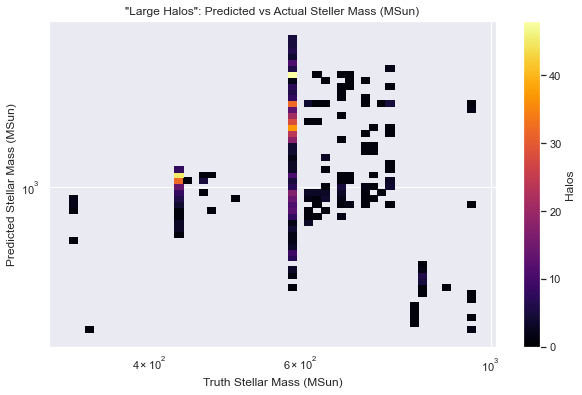

In [ ]:
# Histogram params
num_x_bins = 50
num_y_bins = 50

# Set the minimum and maximum values for the x-axis and y-axis
x_min, x_max = np.min(y_truth_small), np.max(y_truth_small)
y_min, y_max = np.min(y_pred_small), np.max(y_pred_small)

# Create logarithmically spaced bins for the x-axis and y-axis
x_bins = np.logspace(np.log10(x_min), np.log10(x_max), num_x_bins + 1)
y_bins = np.logspace(np.log10(y_min), np.log10(y_max), num_y_bins + 1)

ax = sns.histplot(x=y_truth_small, y=y_pred_small, bins=[x_bins, y_bins], cmap='inferno')
ax.set_title('"Large Halos": Predicted vs Actual Steller Mass (MSun)')
ax.set_xlabel('Truth Stellar Mass (MSun)')
ax.set_ylabel('Predicted Stellar Mass (MSun)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.colorbar(ax.collections[0], ax=ax, label='Halos')

Mean absolute error: 51.7620414279021%


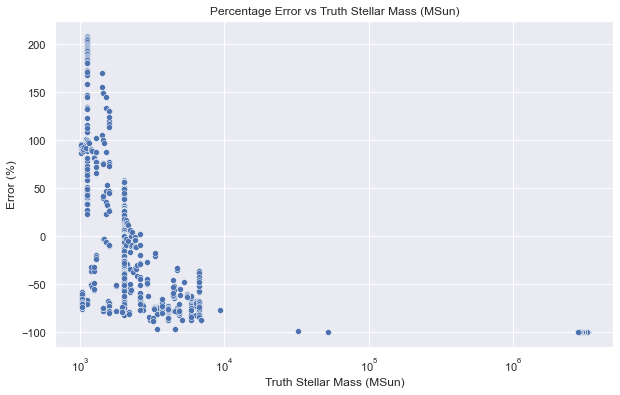

In [ ]:
error = ((y_pred_large - y_truth_large) / y_truth_large) * 100
ax = sns.scatterplot(x=y_truth_large, y=error)
ax.set_xscale('log')
ax.set_title('Percentage Error vs Truth Stellar Mass (MSun)')
ax.set_ylabel('Error (%)')
ax.set_xlabel('Truth Stellar Mass (MSun)')
print(f'Mean absolute error: {np.mean(np.abs(error))}%')

Mean absolute error: 153.65844439056522%


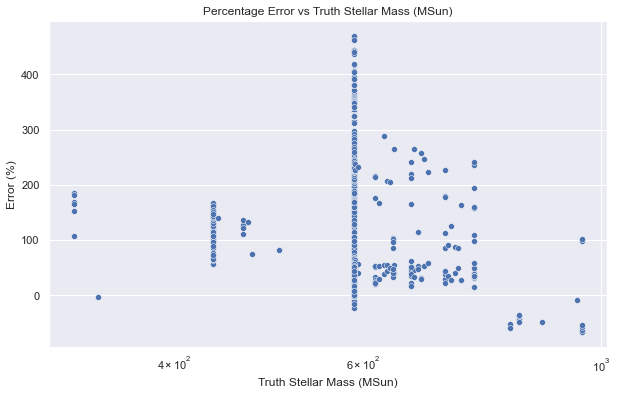

In [ ]:
error = ((y_pred_small - y_truth_small) / y_truth_small) * 100
ax = sns.scatterplot(x=y_truth_small, y=error)
ax.set_xscale('log')
ax.set_title('Percentage Error vs Truth Stellar Mass (MSun)')
ax.set_ylabel('Error (%)')
ax.set_xlabel('Truth Stellar Mass (MSun)')
print(f'Mean absolute error: {np.mean(np.abs(error))}%')